In [2]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
#import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from keras.layers import Dense, LSTM
from numpy import array
from sklearn.metrics import mean_squared_error
from math import sqrt


In [3]:
data = yf.download('AAPL','2008-01-01','2023-03-15')
new_data = yf.download('AAPL','2023-03-16')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
print(new_data)

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-03-16  152.160004  156.460007  151.639999  155.850006  155.850006   
2023-03-17  156.080002  156.740005  154.279999  155.000000  155.000000   
2023-03-20  155.070007  157.820007  154.149994  157.399994  157.399994   

              Volume  
Date                  
2023-03-16  76161100  
2023-03-17  98862500  
2023-03-20  73556400  


In [5]:
#Create an array from date 2023-03-15 to 30 days in future 
future_dates = pd.date_range(start='2023-03-15', end='2023-04-13')
#print(future_dates)

#convert it to an array
future_dates = future_dates.to_numpy()
print(future_dates)

future_dates.shape




['2023-03-15T00:00:00.000000000' '2023-03-16T00:00:00.000000000'
 '2023-03-17T00:00:00.000000000' '2023-03-18T00:00:00.000000000'
 '2023-03-19T00:00:00.000000000' '2023-03-20T00:00:00.000000000'
 '2023-03-21T00:00:00.000000000' '2023-03-22T00:00:00.000000000'
 '2023-03-23T00:00:00.000000000' '2023-03-24T00:00:00.000000000'
 '2023-03-25T00:00:00.000000000' '2023-03-26T00:00:00.000000000'
 '2023-03-27T00:00:00.000000000' '2023-03-28T00:00:00.000000000'
 '2023-03-29T00:00:00.000000000' '2023-03-30T00:00:00.000000000'
 '2023-03-31T00:00:00.000000000' '2023-04-01T00:00:00.000000000'
 '2023-04-02T00:00:00.000000000' '2023-04-03T00:00:00.000000000'
 '2023-04-04T00:00:00.000000000' '2023-04-05T00:00:00.000000000'
 '2023-04-06T00:00:00.000000000' '2023-04-07T00:00:00.000000000'
 '2023-04-08T00:00:00.000000000' '2023-04-09T00:00:00.000000000'
 '2023-04-10T00:00:00.000000000' '2023-04-11T00:00:00.000000000'
 '2023-04-12T00:00:00.000000000' '2023-04-13T00:00:00.000000000']


(30,)

In [6]:
#Create empty array of size 30
actual_thirtydays_values = np.empty((30,1))

#Fill the empty array with NaN values
actual_thirtydays_values[:] = np.nan

for i in range(0,30):
  try:
    actual_thirtydays_values[i] = new_data['Close'][i]
  except:
    actual_thirtydays_values[i] = np.nan
    

#Add the date and the actual values to the dataframe
actual_thirtydays_values = pd.DataFrame(actual_thirtydays_values, columns=['Close'])
actual_thirtydays_values['Date'] = future_dates
actual_thirtydays_values = actual_thirtydays_values.set_index('Date')

print (actual_thirtydays_values)

                 Close
Date                  
2023-03-15  155.850006
2023-03-16  155.000000
2023-03-17  157.399994
2023-03-18         NaN
2023-03-19         NaN
2023-03-20         NaN
2023-03-21         NaN
2023-03-22         NaN
2023-03-23         NaN
2023-03-24         NaN
2023-03-25         NaN
2023-03-26         NaN
2023-03-27         NaN
2023-03-28         NaN
2023-03-29         NaN
2023-03-30         NaN
2023-03-31         NaN
2023-04-01         NaN
2023-04-02         NaN
2023-04-03         NaN
2023-04-04         NaN
2023-04-05         NaN
2023-04-06         NaN
2023-04-07         NaN
2023-04-08         NaN
2023-04-09         NaN
2023-04-10         NaN
2023-04-11         NaN
2023-04-12         NaN
2023-04-13         NaN


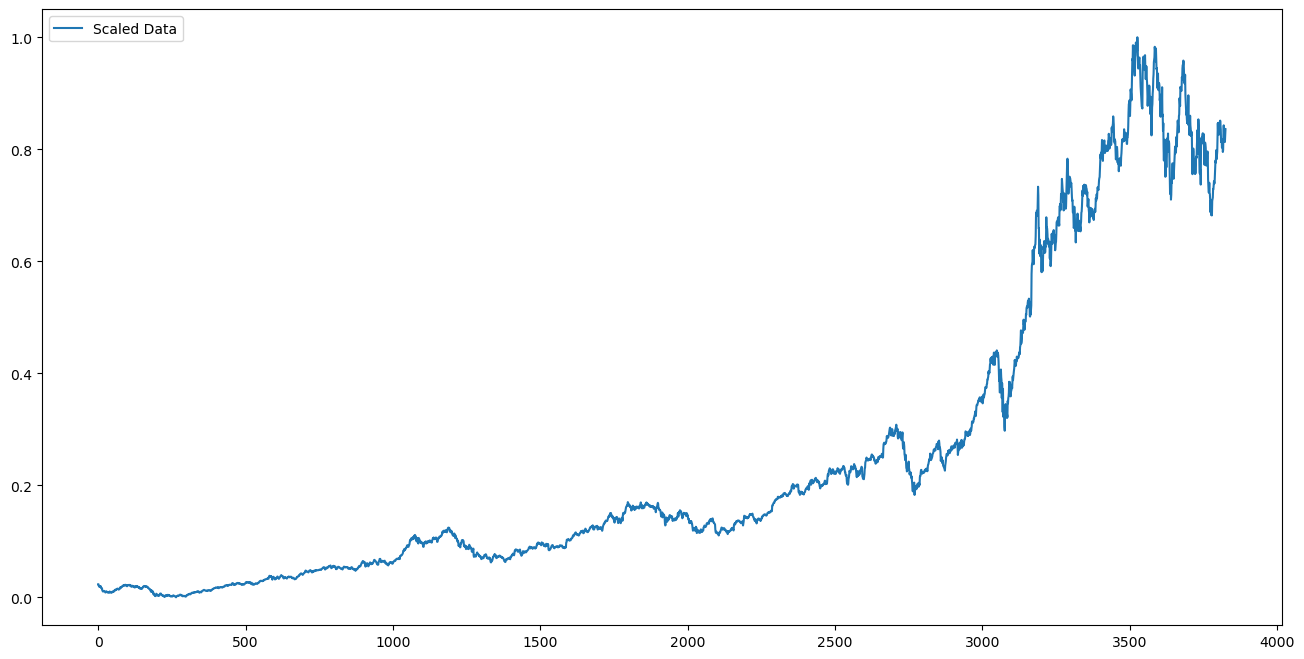

In [7]:
#Scale the data and plot the scaled data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

#plot the scaled data from day 0 to current day
plt.figure(figsize=(16,8))
plt.plot(scaled_data, label='Scaled Data')
plt.legend(loc='upper left')
plt.show()

In [8]:
scaled_data.shape

(3826, 1)

In [9]:
print(scaled_data)

[[0.02324395]
 [0.02326189]
 [0.02029661]
 ...
 [0.81302014]
 [0.8240124 ]
 [0.8358416 ]]


In [10]:
#Create a new dataframe with only the 'Close' column
data = data.filter(['Close'])

#Convert the dataframe to a numpy array
dataset = data.values

#Get the number of rows to train the model on (80% of the data)
training_size = int(np.ceil( len(scaled_data) * .8 ))
test_size = int(np.ceil( len(scaled_data) * .2 ))

#2860 is 80 percent of the total number of rows in the dataset
print("Total Rows in Training Dataset: ", training_size)
print("Total Rows in Testing Dataset: ", test_size)

Total Rows in Training Dataset:  3061
Total Rows in Testing Dataset:  766


In [11]:
#Split the data in to training and testing data, 80% training and 20% testing starting from the beginning of the dataset
train_data = scaled_data[0:training_size , :]
test_data = scaled_data[training_size:len(scaled_data), :]

#remove null values
train_data = train_data[~np.isnan(train_data).any(axis=1)]
test_data = test_data[~np.isnan(test_data).any(axis=1)]

#print the shape of the training and testing data
print("Training Data Shape: ", train_data.shape)
print("Testing Data Shape: ", test_data.shape)

Training Data Shape:  (3061, 1)
Testing Data Shape:  (765, 1)


In [12]:
#Time step is the number of days we want to look back to predict the next closing price
#We need use the training data to create the x_train and y_train data sets where x_train is the closing price of the previous 14 years and y_train is the closing price of the next day
#if data is 120, 130, 125, 140, 134, and 150 then x_train would be 120, 130, 125, 140, 134 and y_train would be 150
#We will do the same for the test data and then check the accuracy of the model

#Function to create the x_train and y_train data sets
def create_dataset (dataset, time_step=1):
    dataX, dataY = [], []
    #Loop through the data and create the x_train and y_train data sets
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0] #Start from 0 to time_step and add to a
        dataX.append(a) #Store the values from 0 to time_step in dataX
        dataY.append(dataset[i+time_step, 0]) #Store the value of the next day in dataY
    return np.array(dataX), np.array(dataY) #Return the training data and the testing data as numpy arrays

In [13]:
#time step is the number of days we want to look back to predict the next closing price and we will use 10 days for this model
time_step = 30

#Create the training data set
x_train, y_train = create_dataset(train_data, time_step)

#180 features and 2550 rows
print (x_train.shape) #the training data should have 10 features for 10 days
print (y_train.shape)

(3030, 30)
(3030,)


In [14]:
time_step = 30

#Create the testing data set
x_test, y_test = create_dataset(test_data, time_step)

#180 features an 730 rows
print(x_test.shape)
print(y_test.shape)

(734, 30)
(734,)


In [15]:
#Reshape the data to fit the LSTM model
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [16]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

#Compile the model with the adam optimizer and mean squared error loss function
model.compile(optimizer='adam', loss='mean_squared_error')

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-03-21 00:05:32.571935: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-21 00:05:32.572269: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
#Fit the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2023-03-21 00:05:33.051930: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-21 00:05:34.316113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-21 00:05:34.519029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-21 00:05:34.563311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-21 00:05:34.643781: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x14a01b870
2023-03-21 00:05:34.643809: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x14a01b870
2023-03-21 00:05:34.648974: I tensorflow/core/grapple

NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_8' defined at (most recent call last):
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/asyncio/base_events.py", line 1906, in _run_once
      handle._run()
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/6c/6z47j0dj61g66k6z36qdtd5r0000gn/T/ipykernel_2203/2077774619.py", line 2, in <module>
      model.fit(x_train, y_train, batch_size=1, epochs=1)
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_8'
could not find registered platform with id: 0x14a01b870
	 [[{{node StatefulPartitionedCall_8}}]] [Op:__inference_train_function_5065]

In [ ]:
#Predict the values using the testing data
train_predict = model.predict(x_train)
train_predict = scaler.inverse_transform(train_predict)

95/95 [==============================] - 4s 32ms/step


In [ ]:
#Predict the values using the testing data
test_predict = model.predict(x_test)
test_predict = scaler.inverse_transform(test_predict)

23/23 [==============================] - 1s 21ms/step


In [ ]:
#verify the shape of the training prediction data and the actual data
print(train_predict.shape)
print(data[30:3060].shape)

: 

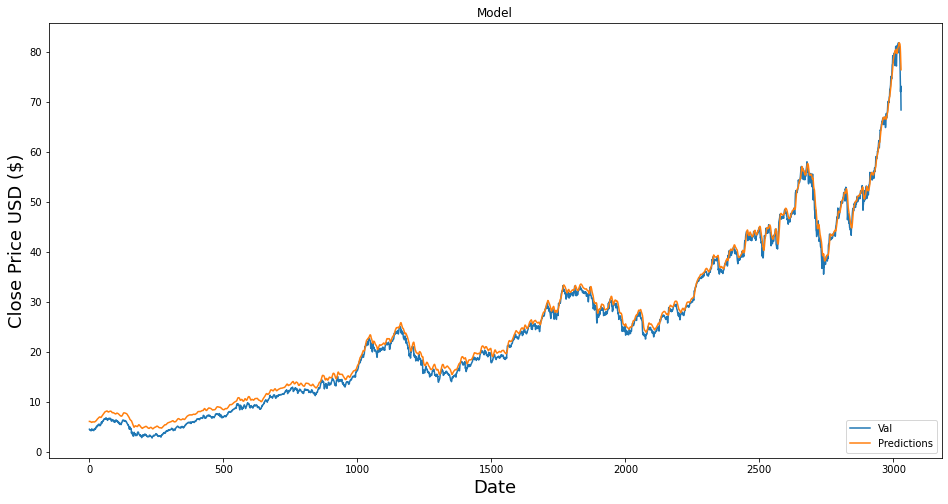

In [ ]:
#Plot the train data and prediction
#Training Data Shape:  (3061, 1)
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(scaler.inverse_transform(scaled_data[30:3060]))
plt.plot(train_predict)
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()


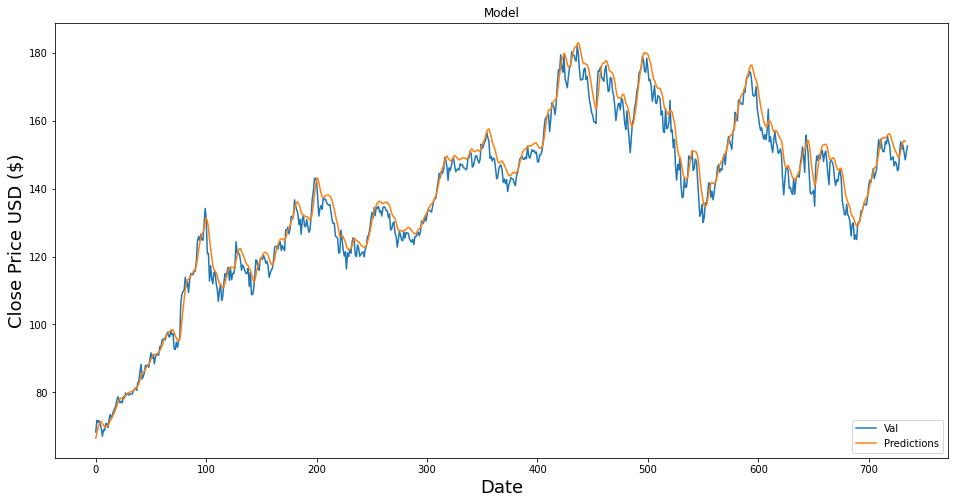

In [ ]:
#Plot the test data and prediction
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
#Plot only the test data
plt.plot(scaler.inverse_transform(scaled_data[3090:]))
plt.plot(test_predict)
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

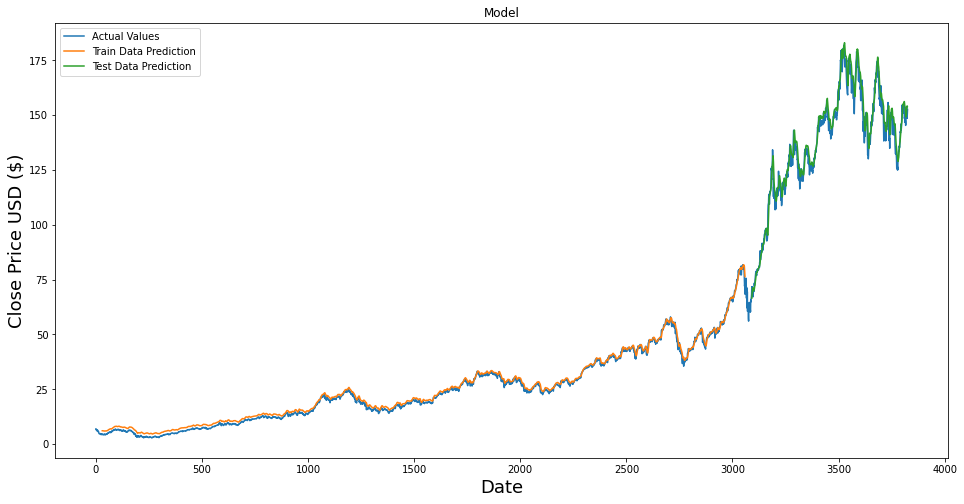

In [ ]:
#Plot the data
look_back = 30
trainPredictPlot = np.empty_like(scaled_data)

trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

#Plot the testing data and the model predictions
testPredictPlot = np.empty_like(scaled_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(scaled_data)-1, :] = test_predict

#Plot the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(scaler.inverse_transform(scaled_data))
plt.plot(trainPredictPlot)
#plt.plot(y_test)
plt.plot(testPredictPlot)
plt.legend(['Actual Values', 'Train Data Prediction', 'Test Data Prediction'], loc='upper left')
plt.show()

In [ ]:
#Get performance metrics for the model on the training and testing data using root mean squared error (RMSE)
trainScore = math.sqrt(mean_squared_error(y_train, train_predict))
testScore = math.sqrt(mean_squared_error(y_test, test_predict))

print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 30.10 RMSE
Test Score: 140.28 RMSE


In [ ]:
len(test_data)

765

In [ ]:
#Training Data Shape:  (3061, 1)
#Testing Data Shape:  (765, 1)
#Get the last 30 days of the training data and convert it to an array (765 - 30 = 735)

x_input = test_data[735:].reshape(1,-1) #Predict the closing price for the next 30 days starting from 685
x_input.shape

(1, 30)

In [ ]:
#Convert the data to a list
temp_input = list(x_input)
temp_input = temp_input[0].tolist() #Convert the data to a list

print(len(temp_input)) #The length of the list should be 30 as we are predicting the closing price for the next 30 days

30


In [ ]:
#Predict the closing price for the next 30 days

lst_output = []
n_steps = 30
i = 0
while(i<30):
      #if the length of the list is greater than 30, then we will shift by 1 day and take new output as the input for the next day prediction
      if(len(temp_input)>30): #
          #print(temp_input)
          x_input = np.array(temp_input[1:])
          print("{} day input {}".format(i,x_input))
          x_input = x_input.reshape(1,-1)
          x_input = x_input.reshape((1, n_steps, 1))
          #print(x_input)
          yhat = model.predict(x_input, verbose=0)
          print("{} day output {}".format(i,yhat))
          temp_input.extend(yhat[0].tolist())
          temp_input = temp_input[1:]
          #print(temp_input)
          lst_output.extend(yhat.tolist())
          i=i+1
      #If the length of the list is less than 30, then we will add the last 30 days to the list and predict the next 30 days
      else:
          x_input = x_input.reshape((1, n_steps,1)) #Reshape the data to fit the model
          yhat = model.predict(x_input, verbose=0)  #Predict the closing price for the next 30 days
          print(yhat[0]) #Print the predicted closing price
          temp_input.extend(yhat[0].tolist()) #Add the predicted closing price to the list
          print(len(temp_input)) #The length of the list should be 30
          lst_output.extend(yhat.tolist()) #Add the predicted closing price to previous list (temp_input)
          i=i+1 

[0.84278643]
31
1 day input [0.79589005 0.82596538 0.84649909 0.83104295 0.84733602 0.83210313
 0.8262443  0.82702547 0.84287223 0.8392453  0.85113035 0.84209106
 0.83561845 0.81290852 0.81530789 0.81804195 0.8030323  0.80978384
 0.80693816 0.79522049 0.79856842 0.82713709 0.84276061 0.83031763
 0.83740395 0.82468196 0.81302014 0.8240124  0.8358416  0.84278643]
1 day output [[0.84608704]]
2 day input [0.82596538 0.84649909 0.83104295 0.84733602 0.83210313 0.8262443
 0.82702547 0.84287223 0.8392453  0.85113035 0.84209106 0.83561845
 0.81290852 0.81530789 0.81804195 0.8030323  0.80978384 0.80693816
 0.79522049 0.79856842 0.82713709 0.84276061 0.83031763 0.83740395
 0.82468196 0.81302014 0.8240124  0.8358416  0.84278643 0.84608704]
2 day output [[0.8504278]]
3 day input [0.84649909 0.83104295 0.84733602 0.83210313 0.8262443  0.82702547
 0.84287223 0.8392453  0.85113035 0.84209106 0.83561845 0.81290852
 0.81530789 0.81804195 0.8030323  0.80978384 0.80693816 0.79522049
 0.79856842 0.8271370

In [ ]:
day_new = np.arange(1,31) #Create a new array with the previous 30 days
day_pred = np.arange(31,61) #Create a new array with the next 30 days

In [ ]:
#Print the predicted closing price for the next 30 days
print(scaler.inverse_transform(lst_output))

[[153.83462874]
 [154.42615411]
 [155.2040941 ]
 [156.07910301]
 [157.00621956]
 [157.96272277]
 [158.93639223]
 [159.92119251]
 [160.91371601]
 [161.91232835]
 [162.91616427]
 [163.92517036]
 [164.93931458]
 [165.9590349 ]
 [166.98458768]
 [168.01642157]
 [169.0547716 ]
 [170.09995821]
 [171.15239803]
 [172.21224058]
 [173.27958203]
 [174.3547535 ]
 [175.43762683]
 [176.52819132]
 [177.62650039]
 [178.73271426]
 [179.84659794]
 [180.96822619]
 [182.09750287]
 [183.2341289 ]]


In [ ]:
#add the predicted closing price to the actual closing price
actual_thirtydays_values['Predictions'] = scaler.inverse_transform(lst_output)

print(actual_thirtydays_values)

                 Close  Predictions
Date                               
2023-03-15  155.850006   153.834629
2023-03-16  155.000000   154.426154
2023-03-17  157.399994   155.204094
2023-03-18         NaN   156.079103
2023-03-19         NaN   157.006220
2023-03-20         NaN   157.962723
2023-03-21         NaN   158.936392
2023-03-22         NaN   159.921193
2023-03-23         NaN   160.913716
2023-03-24         NaN   161.912328
2023-03-25         NaN   162.916164
2023-03-26         NaN   163.925170
2023-03-27         NaN   164.939315
2023-03-28         NaN   165.959035
2023-03-29         NaN   166.984588
2023-03-30         NaN   168.016422
2023-03-31         NaN   169.054772
2023-04-01         NaN   170.099958
2023-04-02         NaN   171.152398
2023-04-03         NaN   172.212241
2023-04-04         NaN   173.279582
2023-04-05         NaN   174.354754
2023-04-06         NaN   175.437627
2023-04-07         NaN   176.528191
2023-04-08         NaN   177.626500
2023-04-09         NaN   178

In [ ]:
#Calculate the accuracy from the actual closing price and the predicted closing price for the next 30 days

#calculate accuray by subtracting the actual closing price and the predicted closing price and divide by the actual closing price and multiply by 100 to get the percentage
accuracy = (actual_thirtydays_values['Close'] - actual_thirtydays_values['Predictions']) / actual_thirtydays_values['Close'] * 100

#add the absolute accuracy to the actual closing price and the predicted closing price 
actual_thirtydays_values['Accuracy'] = abs(accuracy)

print (actual_thirtydays_values)

NameError: name 'actual_thirtydays_values' is not defined